In [1]:
from google.colab import userdata
import os

api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

os.environ["OPENAI_API_BASE"] = "https://api.aimlapi.com/v1"

In [2]:
!pip install -q langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.4 MB/s eta 0:00:00


In [3]:
# Step 0: Install dependencies
!apt-get install graphviz -y
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [4]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableSequence, RunnableLambda, RunnableParallel, RunnablePassthrough
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph
import random

In [5]:
# Basic prompt → model → parser
prompt_basic = ChatPromptTemplate.from_template("Write a short motivational quote about {topic}.")
model_basic = ChatOpenAI(model="gpt-4o-mini")
parser_basic = StrOutputParser()
basic_chain = RunnableSequence(first=prompt_basic, middle=[model_basic], last=parser_basic)

In [6]:
# Modular Runnables
preprocess = RunnableLambda(lambda x: {"topic": x["topic"].title()})
postprocess = RunnableLambda(lambda x: x + " ✨")  # add flair

modular_chain = preprocess | basic_chain | postprocess

In [8]:
# Branches correctly extract their sub-input
branch1 = RunnableLambda(lambda x: modular_chain.invoke(x["branch1"]))
branch2 = RunnableLambda(lambda x: modular_chain.invoke(x["branch2"]))

parallel_chain = RunnableParallel({"branch1": branch1, "branch2": branch2})

# Inputs
parallel_inputs = {
    "branch1": {"topic": "focus"},
    "branch2": {"topic": "happiness"}
}

# Invoke
parallel_results = parallel_chain.invoke(parallel_inputs)
print("Parallel Results:", parallel_results)

Parallel Results: {'branch1': '"Focus is the bridge between dreams and reality; stay steadfast, and success will follow." ✨', 'branch2': '"Happiness is not a destination, but a choice to embrace each moment with gratitude and joy." ✨'}


In [9]:
# Custom chain using RunnableLambda
custom_chain = RunnableLambda(lambda x: modular_chain.invoke({"topic": x["topic"].upper()}))
custom_result = custom_chain.invoke({"topic": "perseverance"})
print("Custom Chain Result:", custom_result)

Custom Chain Result: "Perseverance is the quiet strength that transforms obstacles into stepping stones; keep pushing forward, and the path will reveal itself." ✨


In [10]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=False)

# Prompt uses memory
prompt_memory = ChatPromptTemplate.from_template(
    "Conversation so far:\n{chat_history}\nUser: {user_input}\nAI:"
)
model_memory = ChatOpenAI(model="gpt-4o-mini")

memory_chain = RunnableSequence(
    first=RunnablePassthrough(additional_keys=["chat_history", "user_input"]),
    middle=[prompt_memory, model_memory],
    last=StrOutputParser()
)

# Simulate conversation
user_msgs = ["Hello!", "How are you?", "Give me motivation."]
for msg in user_msgs:
    mem_vars = memory.load_memory_variables({})
    input_dict = {"user_input": msg, "chat_history": mem_vars["chat_history"]}
    response = memory_chain.invoke(input_dict)
    print("AI:", response)
    memory.save_context({"user_input": msg}, {"output": response})

/tmp/ipython-input-2150494083.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=False)


AI: Hi there! How can I assist you today?
AI: I'm just a program, but I'm here and ready to help! How about you? How are you doing?
AI: Absolutely! Remember that every step you take, no matter how small, brings you closer to your goals. Believe in yourself and your abilities; you have the strength to overcome challenges. Embrace the journey, and don’t forget to celebrate your progress along the way. You’ve got this! What are you working towards?


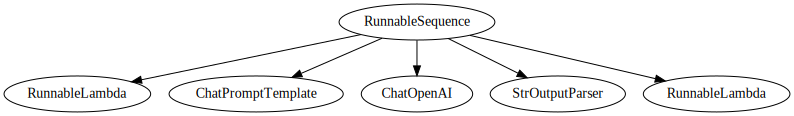

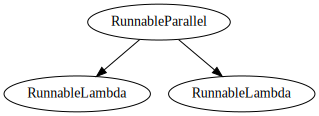

In [11]:
def visualize_chain(chain, graph=None, parent=None, name="root"):
    if graph is None:
        graph = Digraph(comment="LangChain Graph")
    graph.node(name, type(chain).__name__)
    if parent:
        graph.edge(parent, name)
    if isinstance(chain, RunnableSequence):
        if chain.first:
            visualize_chain(chain.first, graph, parent=name, name=name+"_first")
        for i, mid in enumerate(chain.middle):
            visualize_chain(mid, graph, parent=name, name=f"{name}_mid{i}")
        if chain.last:
            visualize_chain(chain.last, graph, parent=name, name=name+"_last")
    elif isinstance(chain, RunnableParallel):
        branches = getattr(chain, "steps__", {})
        for branch_name, branch_runnable in branches.items():
            visualize_chain(branch_runnable, graph, parent=name, name=f"{name}_{branch_name}")
    return graph

graph1 = visualize_chain(modular_chain)
graph2 = visualize_chain(parallel_chain)

display(graph1)
display(graph2)

In [12]:
def evaluate_chain(chain, topics):
    results = []
    for topic in topics:
        output = chain.invoke({"topic": topic})
        score = len(output.split())  # simple metric: number of words
        results.append({"topic": topic, "output": output, "score": score})
    return results

topics = ["focus", "happiness", "perseverance"]
eval_results = evaluate_chain(modular_chain, topics)

for r in eval_results:
    print(f"Topic: {r['topic']}, Score: {r['score']}, Output: {r['output']}")

Topic: focus, Score: 16, Output: "Where your focus goes, your energy flows; channel it wisely and watch your dreams unfold." ✨
Topic: happiness, Score: 15, Output: "Happiness is not a destination; it's the journey we create with each joyful moment." ✨
Topic: perseverance, Score: 22, Output: "Perseverance is the bridge between dreams and reality; every step forward, no matter how small, brings you closer to your goals." ✨


##Features in Workflow

1	Basic prompt → model → parser

2	Modular RunnableSequences with preprocessing/postprocessing

3	Parallel chains and concurrency

4	Custom logic with RunnableLambda

5	Memory for stateful conversations

6	Graph visualization of chains

7	Evaluation and scoring of outputs